# Fine-tune Enformer to perform binary classification on human snATAC-seq data

In this tutorial, we learn how to fine-tune the Enformer model (https://www.nature.com/articles/s41592-021-01252-x) on the CATLAS single-nucleus ATAC-seq dataset from human tissues (http://catlas.org/humanenhancer/). 

We will perform binary classification, in which the model learns to predict the probability that a given sequence is accessible in the different cell types of the dataset. For an example of regression modeling, see the next tutorial.

In [1]:
import anndata
import os
import importlib
import pandas as pd
import numpy as np

%matplotlib inline

## Set experiment parameters

In [2]:
experiment='tutorial_2'
if not os.path.exists(experiment):
    os.makedirs(experiment)

## Download data

We download the CATlas ATAC-seq binary cell type x peak matrix from the gReLU model zoo. For more details on downloading models and datasets from the zoo, see Tutorial 6. The original source of this data is https://decoder-genetics.wustl.edu/catlasv1/humanenhancer/data/cCRE_by_cell_type/. For more details, see https://decoder-genetics.wustl.edu/catlasv1/catlas_humanenhancer/#!/.

In [3]:
import grelu.resources
artifact = grelu.resources.get_artifact(
    name="dataset",
    project = 'tutorial-2',
)
artifact_dir = artifact.download()
os.listdir(artifact_dir)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: avantikalal (grelu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact dataset:latest, 206.94MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (308.3MB/s)


['data.h5ad']

## Load data

As you see above, we downloaded an h5ad file `data.h5ad` containing the binaized chromatin accessibility data for multiple human cell types. We now load this as an anndata object.

In [4]:
ad = anndata.read_h5ad(os.path.join(artifact_dir, 'data.h5ad'))
ad

AnnData object with n_obs × n_vars = 222 × 1154611
    obs: 'cell type'
    var: 'chrom', 'start', 'end', 'Class', 'Present in fetal tissues', 'Present in adult tissues', 'CRE module', 'width'

This contains a binary matrix representing the accessibility of 1154611 CREs measured in 222 cell types. Let us look at the components of this object:

In [5]:
ad.var.head()

,chrom,start,end,Class,Present in fetal tissues,Present in adult tissues,CRE module,width
0,chr1,9955,10355,Promoter Proximal,yes,yes,146,400
1,chr1,29163,29563,Promoter,yes,yes,37,400
2,chr1,79215,79615,Distal,no,yes,75,400
3,chr1,102755,103155,Distal,no,yes,51,400
4,chr1,115530,115930,Distal,yes,no,36,400


In [6]:
ad.obs.head()

,cell type
cell type,
Follicular,Follicular
Fibro General,Fibro General
Acinar,Acinar
T Lymphocyte 1 (CD8+),T Lymphocyte 1 (CD8+)
T lymphocyte 2 (CD4+),T lymphocyte 2 (CD4+)


The contents of this anndata object are binary values (0 or 1). 1 indicates accessibility of the peak in the cell type.

In [7]:
ad.X[:5, :5].todense()

matrix([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], dtype=float32)

## Filter peaks

We will perform filtering of this dataset using the `grelu.data.preprocess` module.

First, we filter peaks within autosomes (chromosomes 1-22) or chromsomes X/Y. You can also supply `autosomes` or `autosomesX` to further restrict the chromosomes.

In [8]:
import grelu.data.preprocess

ad = grelu.data.preprocess.filter_chromosomes(ad, 'autosomesXY')

Keeping 1154464 intervals


Next, we drop peaks overlapping with the ENCODE blacklist regions for the hg38 genome.

In [9]:
ad = grelu.data.preprocess.filter_blacklist(ad, genome='hg38')

Keeping 1154464 intervals


## Visualize data

Next, we can plot the distribution of the data in various ways.

In [10]:
import grelu.visualize
%matplotlib inline

In how many accessible cell types is each peak accessible?

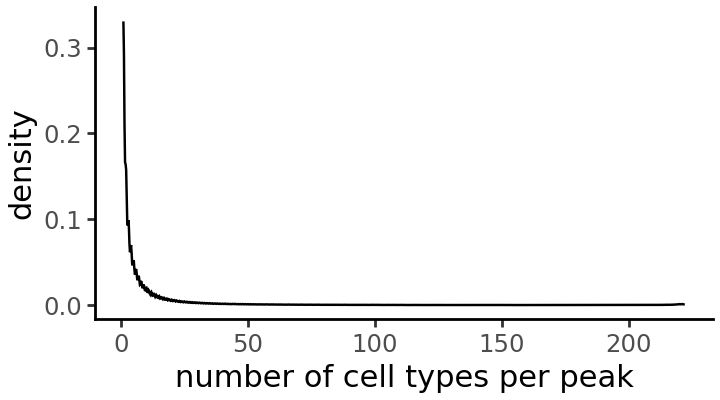

In [11]:
cell_types_per_peak = np.array(np.sum(ad.X > 0, axis=0))

grelu.visualize.plot_distribution(
    cell_types_per_peak,
    title='number of cell types per peak',
    method='density', # Alternative: histogram
    figsize=(3.6, 2), # width, height
)

How many peaks are accessible in each cell type?

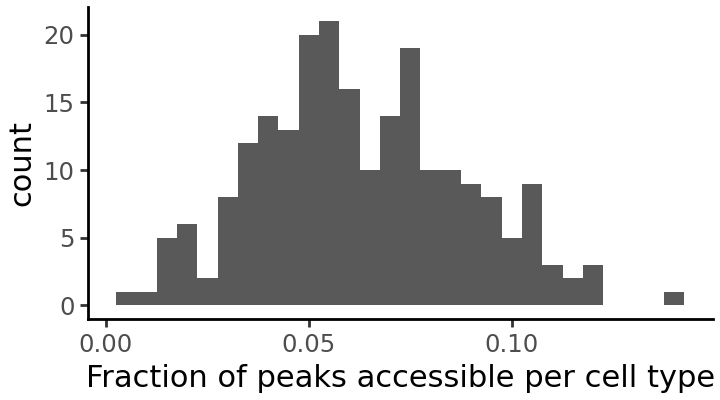

In [12]:
fraction_accessible_per_cell_type = np.array(np.mean(ad.X > 0, axis=1))

grelu.visualize.plot_distribution(
    fraction_accessible_per_cell_type,
    title='Fraction of peaks accessible per cell type',
    method='histogram', # alternative: density
    binwidth=0.005,
    figsize=(3.6, 2), # width, height
)

It seems that some cell types have very few accessible peaks. We will drop these cell types from the dataset.

In [13]:
print(ad.shape)
ad = ad[ad.X.mean(axis=1) > .03, :]
print(ad.shape)

(222, 1154464)
(203, 1154464)


We can plot the distribution once again to see the effect of this filtering:

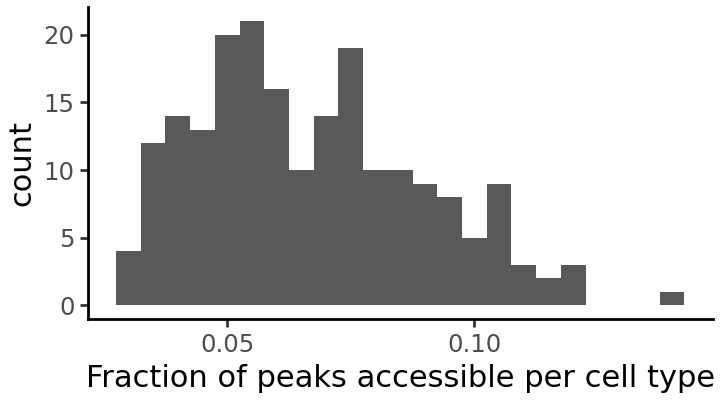

In [14]:
fraction_accessible_per_cell_type = np.array(np.mean(ad.X > 0, axis=1))

grelu.visualize.plot_distribution(
    fraction_accessible_per_cell_type,
    title='Fraction of peaks accessible per cell type',
    method='histogram', # alternative: density
    binwidth=0.005,
    figsize=(3.6, 2), # width, height
)

## Resize peaks

Finally, since the ATAC-seq peaks can have different lengths, we resize all of them to a constant length in order to train the model. Here, we take 200 bp. We can use the `resize` function in `grelu.sequence.utils`, which contains functions to manipulate DNA sequences.

In [15]:
import grelu.sequence.utils
seq_len = 200

ad.var = grelu.sequence.utils.resize(ad.var, seq_len)
ad.var.head(3)

,chrom,start,end,Class,Present in fetal tissues,Present in adult tissues,CRE module,width
0,chr1,10055,10255,Promoter Proximal,yes,yes,146,400
1,chr1,29263,29463,Promoter,yes,yes,37,400
2,chr1,79315,79515,Distal,no,yes,75,400


## Split data

We will split the peaks by chromosome to create separate sets for training, validation and testing.

In [16]:
train_chroms='autosomes'
val_chroms=['chr10']
test_chroms=['chr11']

ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad,
    train_chroms=train_chroms, val_chroms=val_chroms, test_chroms=test_chroms,
)

Selecting training samples
Keeping 1007912 intervals


Selecting validation samples
Keeping 56974 intervals


Selecting test samples
Keeping 56433 intervals
Final sizes: train: (203, 1007912), val: (203, 56974), test: (203, 56433)


## Make labeled sequence datasets

`grelu.data.dataset` contains PyTorch Dataset classes that can load and process genomic data for training a deep learning model. Here, we use the `AnnDataSeqDataset` class which loads data from an AnnData object. Other available dataset classes include `DFSeqDataset` and `BigWigSeqDataset`.

We first make the training dataset. To increase model robustness we use several forms of data augmentation here: `rc=True` (reverse complementing the input sequence), and `max_seq_shift=1` (shifting the coordinates of the input sequence by upto 1 bp in either direction; also known as jitter). We use `augmentation_mode="random"` which means that at each iteration, the model sees a randomly selected augmented version for each sequence.

In [17]:
import grelu.data.dataset

In [18]:
train_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_train.copy(),
    genome='hg38',
    rc=True, # reverse complement
    max_seq_shift=1, # Shift the sequence
    augment_mode="random", # Randomly select which augmentations to apply
)

We do not apply any augmentations to the validation and test datasets (although it is possible to do so).

In [19]:
val_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_val.copy(), genome='hg38')
test_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_test.copy(), genome='hg38')

## Build the enformer model

gReLU contains many model architectures. One of these is a class called `EnformerPretrainedModel`. This class creates a model identical to the published Enformer model and initialized with the trained weights, but where you can change the number of transformer layers and the output head.

Models are created using the `grelu.lightning` module. In order to instantiate a model, we need to specify `model_params` (parameters for the model architecture) and `train_params` (parameters for training).

In [22]:
model_params = {
    'model_type':'EnformerPretrainedModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, # No cropping of the model output
    'n_transformers': 1, # Number of transformer layers; the published Enformer model has 11
}

train_params = {
    'task':'binary', # binary classification
    'lr':1e-4, # learning rate
    'logger': 'csv', # Logs will be written to a CSV file
    'batch_size': 1024,
    'num_workers': 8,
    'devices': 0, # GPU index
    'save_dir': experiment,
    'optimizer': 'adam',
    'max_epochs': 10,
    'checkpoint': True, # Save checkpoints
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params=model_params, train_params=train_params)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2 (759.0MB/s)


## Train the model

We train the model on the new training dataset using the `train_on_dataset` method. Note that here, we update the weights of the entire model during training. If you want to hold the enformer weights fixed and only learn a linear layer from the enformer embedding to the outputs, see the `tune_on_dataset` method.

In [23]:
# See the 'tutorial_2' folder for logs
trainer = model.train_on_dataset(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|██████████████████████████████████████████████| 56/56 [00:07<00:00,  7.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5030279159545898     │
│         val_auroc         │    0.5081552267074585     │
│        val_avgprec        │    0.11099189519882202    │
│        val_best_f1        │    0.1738046109676361     │
│         val_loss          │    0.6936386823654175     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | model        | EnformerPretrainedModel | 72.1 M | train
1 | loss         | BCEWithLogitsLoss       | 0      | train
2 | val_metrics  | MetricCollection        | 0      | train
3 | test_metrics | MetricCollection        | 0      | train
4 | transform    | Identity                | 0      | train
-----------------------------------------------------------------
72.1 M    Trainable params
0         Non-trainable params
72.1 M    Total params
288.267   Total estimated model params size (MB)
240       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|████████████████████████████| 985/985 [03:13<00:00,  5.10it/s, v_num=0, train_loss_step=0.146]
Validation: |                                                                         | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████| 985/985 [03:13<00:00,  5.08it/s, v_num=0, train_loss_step=0.147, train_loss_epoch=0.170]
Validation: |                                                                         | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████| 985/985 [03:13<00:00,  5.09it/s, v_num=0, train_loss_step=0.159, train_loss_epoch=0.151]
Validation: |                                                                         | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████| 985/985 [03:13<00:00,  5.09it/s, v_num=0, train_loss_step=0.152, train_loss_epoch=0.148]
Validation: |                                                                         | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|████| 985/985 [03:13<00:00,  5.08it/s, v_num=0, train_loss_step=0.159, train_loss_epoch=0.146]
Validation: |      

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████| 985/985 [03:26<00:00,  4.77it/s, v_num=0, train_loss_step=0.129, train_loss_epoch=0.140]


## Load best model from checkpoint

During training, the performance of the model on the validation set is checked after each epoch. We will load the version of the model that had the best validation set performance.

In [24]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

tutorial_2/2025_08_08_23_29/version_0/checkpoints/epoch=6-step=6895.ckpt


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3 (734.1MB/s)
/opt/conda/lib/python3.11/site-packages/grelu/model/models.py:803: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Ple

## Calculate performance metrics on the test set

We calculate global performance metrics using the `test_on_dataset` method.

In [25]:
test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=1024,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████| 56/56 [00:06<00:00,  9.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9458138942718506     │
│        test_auroc         │    0.9045498967170715     │
│       test_avgprec        │    0.6065452098846436     │
│       test_best_f1        │    0.5680147409439087     │
│         test_loss         │    0.1548745334148407     │
└───────────────────────────┴───────────────────────────┘

`test_metrics` is a dataframe containing metrics for each model task.

In [26]:
test_metrics.head()

,test_accuracy,test_auroc,test_avgprec,test_best_f1
Follicular,0.908724,0.879193,0.626169,0.578588
Fibro General,0.916326,0.882369,0.624288,0.575663
Acinar,0.944128,0.913832,0.649700,0.600823
T Lymphocyte 1 (CD8+),0.961104,0.930530,0.633522,0.592739
T lymphocyte 2 (CD4+),0.966757,0.939184,0.617657,0.573524


## Visualize performance metrics

We can plot the distribution of each metric across all cell types:

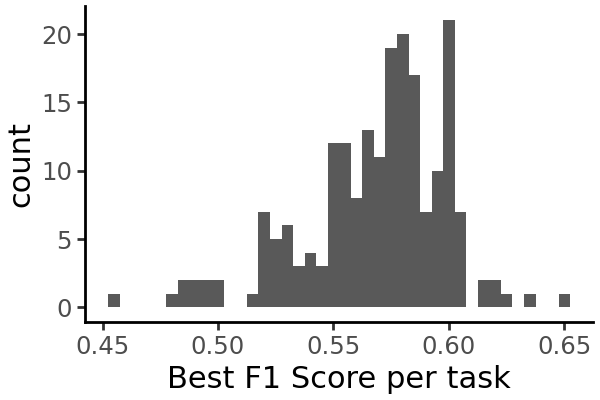

In [27]:
grelu.visualize.plot_distribution(
    test_metrics.test_best_f1,
    method='histogram',
    title='Best F1 Score per task',
    binwidth=0.005,
    figsize=(3,2),
)

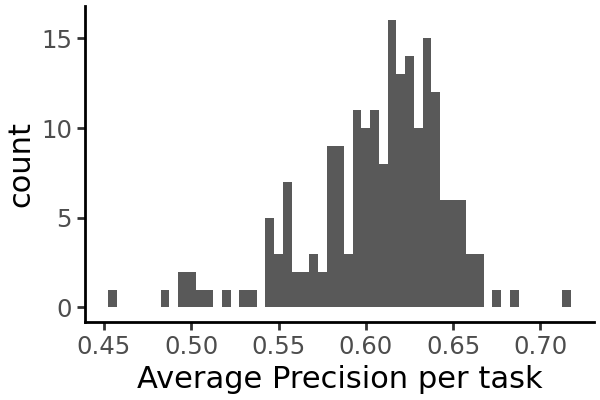

In [28]:
grelu.visualize.plot_distribution(
    test_metrics.test_avgprec,
    method='histogram',
    title='Average Precision per task',
    binwidth=0.005,
    figsize=(3,2),
)

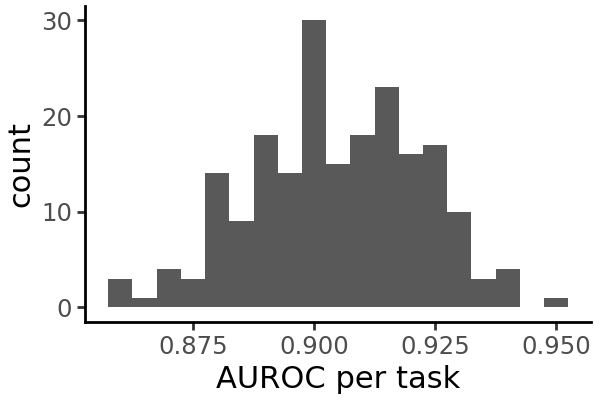

In [29]:
grelu.visualize.plot_distribution(
    test_metrics.test_auroc,
    method='histogram',
    title='AUROC per task',
    binwidth=0.005,
    figsize=(3,2),
)

## Run inference on the test set

Instead of overall metrics, we can also get the individual predictions for each test set example.

In [30]:
probs = model.predict_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=1024,
    return_df=True # Return the output as a pandas dataframe
)

probs.head()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 56/56 [00:03<00:00, 14.17it/s]


,Follicular,Fibro General,Acinar,T Lymphocyte 1 (CD8+),T lymphocyte 2 (CD4+),Natural Killer T,Naive T,Fibro Epithelial,Cardiac Pericyte 1,Pericyte General 1,...,Fetal Cardiac Fibroblast,Fetal Fibro General 2,Fetal Fibro Muscle 1,Fetal Fibro General 3,Fetal Mesangial 2,Fetal Stellate,Fetal Alveolar Epithelial 1,Fetal Cilliated,Fetal Excitatory Neuron 1,Fetal Excitatory Neuron 2
0,0.212833,0.611864,0.334547,0.667248,0.359331,0.305729,0.392535,0.529601,0.255334,0.565867,...,0.082003,0.101487,0.101913,0.101705,0.109245,0.041238,0.115485,0.060792,0.148941,0.033144
1,0.008077,0.021298,0.001778,0.087957,0.104186,0.039692,0.020076,0.005464,0.033182,0.004245,...,0.055374,0.016801,0.009305,0.014936,0.006771,0.017647,0.021076,0.009268,0.019644,0.009579
2,0.011849,0.023852,0.009368,0.036790,0.025965,0.043072,0.011761,0.024876,0.073394,0.011559,...,0.031714,0.011118,0.016501,0.025617,0.015859,0.010510,0.013655,0.012846,0.195682,0.020371
3,0.839731,0.858924,0.882282,0.798909,0.828403,0.740011,0.769896,0.757948,0.803414,0.722231,...,0.834718,0.828456,0.788251,0.839180,0.792963,0.707644,0.878509,0.858247,0.791616,0.530717
4,0.266201,0.341110,0.304534,0.549160,0.471074,0.262215,0.301424,0.193280,0.177328,0.225119,...,0.142015,0.167671,0.150591,0.209051,0.124378,0.137615,0.331137,0.251757,0.149968,0.076462


Since this is a binary classification model, the output takes the form of probabilities ranging from 0 to 1. We interpret these as the predicted probabilities of the element being accessible in each cell type.

## Plot additional visualizations of the test set predictions

We can plot a calibration curve for all the tasks. This shows us the fraction of true positive examples, for different levels of model-predicted probability. 

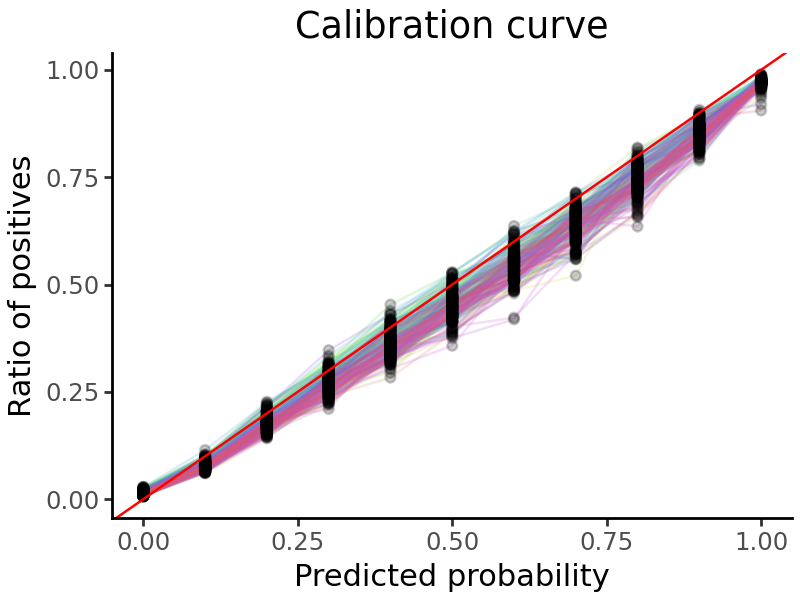

In [31]:
grelu.visualize.plot_calibration_curve(
    probs, labels=test_dataset.labels, aggregate=False, show_legend=False
)

We can also pick any cell type and compare the predictions on accessible and non-accessible elements.

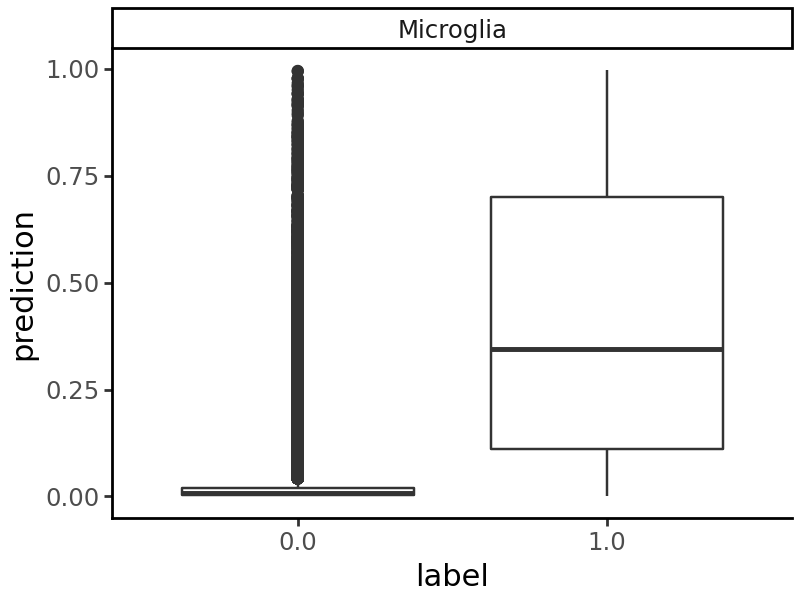

In [32]:
grelu.visualize.plot_binary_preds(
    probs,
    labels=test_dataset.labels,
    tasks='Microglia',
    figure_size=(3, 2) # Width, height
)

## Interpret model predictions (for microglia) using TF-modisco

Suppose we want to focus specifically on Microglia. We can create a transform - a class that takes in the model's prediction and returns a function of the prediction, e.g. the prediction for only a subset of cell types that we are interested in. Then, all subsquent analyses that we do will be based only on this subset of the full prediction matrix.

Transforms can also compute more complicated functions of the model's output - for example, the `Specificity` class of transforms take in the full set of predictions produced by the model and compute the predicted specificity of each sequence to a particular cell type or otuput track.

In this example, we use the `Specificity` transform to analyze the predicted cell type specificity of sequences in microglia - i.e. the predicted accessibility in microglia minus the mean predicted accessibility in other cell types. See the `Aggregate` class if you want to just subset the predictions to microglia.

In [33]:
from grelu.transforms.prediction_transforms import Specificity

microglia_scorer = Specificity(
    on_tasks = ["Microglia"],
    model = model,
    compare_func='subtract' # Subtract the prediction in other cell types from the prediction in microglia
)

The simplest way to use a transform is to apply it directly to the model's predictions using the `.compute()` method. Here, we apply this microglia specificity transform to the test set predictions:

In [34]:
# Transforms expect a 3-D input - add an axis 2 to the predictions.
mcg_specificity = microglia_scorer.compute(np.expand_dims(probs, 2)).squeeze()

# This is the predicted specificity for each test sequence in microglia
mcg_specificity[:5]

array([-0.1008111 , -0.00918946,  0.05977033, -0.27425814, -0.15814793],
      dtype=float32)

We can now select the 250 test set peaks with the highest predicted specificity in microglia:

In [35]:
mcg_peaks = ad.var.iloc[np.argsort(mcg_specificity)].tail(250)
mcg_peaks

,chrom,start,end,Class,Present in fetal tissues,Present in adult tissues,CRE module,width
22392,chr1,43573501,43573701,Distal,yes,yes,106,400
44056,chr1,96126748,96126948,Distal,yes,no,94,400
32372,chr1,65359555,65359755,Distal,no,yes,67,400
23957,chr1,46772642,46772842,Distal,no,yes,150,400
47737,chr1,108913166,108913366,Distal,yes,yes,37,400
...,...,...,...,...,...,...,...,...
46517,chr1,103765391,103765591,Distal,yes,no,72,400
55023,chr1,150557777,150557977,Promoter,no,yes,7,400
52625,chr1,118788443,118788643,Distal,yes,yes,114,400
18728,chr1,36232525,36232725,Distal,yes,yes,52,400


But transforms are more powerful than this - they allow you to do any downstream task, e.g. interpretation, variant effect prediction and design, with respect to the computed quantity. 

Here, we will run TF-Modisco on these selected peaks. TF-Modisco identifies motifs that consistently contribute to the model's output. Since we are using the `microglia_scorer` filter to compute predicted specificity to microglia, we will only get motifs that contribute to increased or decreased specificity. We also use TOMTOM to match the TF-Modisco motifs to a set of reference motifs. Here, we use the HOCOMOCO v12 motif set (https://hocomoco12.autosome.org/).

See the subsequent tutorials for more examples of how to use transforms.

In [38]:
%%time
import grelu.interpret.modisco
grelu.interpret.modisco.run_modisco(
    model,
    seqs=mcg_peaks, 
    genome="hg38",
    prediction_transform=microglia_scorer, # Attributions will be calculated with respect to this output
    meme_file="hocomoco_v13", # We will compare the Modisco CWMs to HOCOMOCO motifs
    method="saliency", # Base-level attribution scores will be calculated using saliency. You can also use ISM here.
    correct_grad=True, # Gradient correction; only applied with saliency
    out_dir=experiment,
    batch_size=256,
    devices=0,
    num_workers=32,
    seed=0,

    # Here, we are demonstrating this function on a small number of peaks,
    # So we set these modisco parameters to a low value. In real runs, we suggest
    # using larger or default values.
    min_metacluster_size=6,
    final_min_cluster_size=6,    
)

Getting attributions


/opt/conda/lib/python3.11/site-packages/grelu/interpret/score.py:172: UserWarning: hypothetical = True will be ignored as method is not deepshap.
/opt/conda/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


Running modisco
3 positive and 7 negative patterns were found.
Writing modisco output
Creating sequence logos
Validation DataLoader 0:   0%|                                                       | 0/56 [46:39<?, ?it/s]
Creating html report
Running TOMTOM
CPU times: user 58min 31s, sys: 11.4 s, total: 58min 42s
Wall time: 1min 47s


## Load TOMTOM output for modisco motifs

The full output of TF-Modisco and TOMTOM can be found in the experiment folder. Here, we read the output of TOMTOM and list the significant TOMTOM matches, i.e. known TF motifs that are similar to those found by TF-MoDISco.

In [43]:
tomtom_file = os.path.join(experiment, 'tomtom.csv')
tomtom = pd.read_csv(tomtom_file, index_col=0)

tomtom[tomtom['q-value'] < 0.005] # Display most significant matches

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
183,pos_pattern_0,ELF5.H13CORE.0.PSM.A,2.0,3.444588e-07,0.000555,0.000951,10.0,ACTTCCTCAT,AGGAAGGAGGAAGTAA,-
218,pos_pattern_0,ETV6.H13CORE.1.P.B,2.0,1.615567e-06,0.002603,0.001505,10.0,ACTTCCTCAT,AAGAGGAAGTGG,-
997,pos_pattern_0,SPI1.H13CORE.0.P.B,2.0,1.061461e-06,0.001710,0.001125,10.0,ACTTCCTCAT,AAAAGAGGAAGTGA,-
998,pos_pattern_0,SPI1.H13CORE.1.S.B,2.0,8.991686e-07,0.001449,0.001125,10.0,ACTTCCTCAT,AAGGGGAAGTAG,-
999,pos_pattern_0,SPIB.H13CORE.0.P.B,5.0,7.849048e-07,0.001264,0.001125,10.0,ACTTCCTCAT,AAAGAGGAAGTGAAAG,-
5376,neg_pattern_0,MAFB.H13CORE.0.PS.A,5.0,4.644735e-06,0.007483,0.002993,7.0,TGACTCA,AATGCTGACTCAGCAATTTT,+
8174,neg_pattern_2,CTCFL.H13CORE.0.P.B,2.0,4.628759e-07,0.000746,0.000951,11.0,CAGCAGAGGGC,GCCGCCAGGGGGCGCC,+
11775,neg_pattern_4,KLF3.H13CORE.0.PS.A,0.0,8.971252e-08,0.000145,0.000482,18.0,ACGCGCCCACACACACCCAGGATGCCATGAATTCACCCAACAAG,GGCTGGGTGGGGCCGGGG,-
11779,neg_pattern_4,KLF6.H13CORE.0.P.B,0.0,1.681598e-06,0.002709,0.001505,18.0,ACGCGCCCACACACACCCAGGATGCCATGAATTCACCCAACAAG,GGAAGGGCGGGGCCGGGG,-
12260,neg_pattern_4,SP2.H13CORE.1.P.B,-1.0,1.071650e-06,0.001726,0.001125,21.0,ACGCGCCCACACACACCCAGGATGCCATGAATTCACCCAACAAG,CCGGCGGGGGGCGGGGCCGGG,-
